---
title: PLM
subtitle: Revisión de completitud
author: Chief Reliability
date: 2023-01-23
---

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
from pathlib import Path

# # Define the path you want to add
# new_path = "/home/cecilvega/PycharmProjects/kverse"  # Path("C:\\Users\\andmn\\PycharmProjects\\kverse")
#
# # Convert Path object to string and append it to sys.path
# sys.path.append(str(new_path))

import pandas as pd
import polars as pl
import dagster as dg
from kdags.resources.dplyr import *
from kdags.resources.tidyr import *
from io import BytesIO
import pdfplumber

# from datetime import datetime
import re
import os
from kdags.definitions import *
from kdags.readr import *
import numpy as np

context = dg.build_asset_context()

from kdags.resources.ggplot import *
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [2]:
haul_df = Readr.Operation.read_haul(context)

In [6]:
df = haul_df.clone()


df = df.with_columns(
    pl.col("peak_sprung_load")
    .rolling_mean_by(by="record_dt", window_size="120d")
    .alias("rolling_fleet_peak_sprung_load")
)
df = df.with_columns(
    pl.col("peak_sprung_load")
    .rolling_mean_by(by="record_dt", window_size="120d")
    .over("equipment_name")
    .alias("rolling_peak_sprung_load")
)
df

total_payload,equipment_name,reserved1,tare_sprung_weight,peak_pos_frame_torque,timepeakposframetorque,peak_neg_frame_torque,timepeaknegframetorque,peak_sprung_load,time_peak_sprung_load,loaded_haul_distance,loaded_haul_time,loaded_stop_time,loaded_max_speed,time_loaded_max_speed,time_body_lift_off,empty_carry_back_load,empty_haul_distance,empty_haul_time,empty_stop_time,empty_max_speed,time_empty_max_speed,loaded_start_time,loading_time,dumping_time,lft_front_tire_ton_mph,rt_front_tire_ton_mph,rear_tire_ton_mph,swingload_num,tare_bin_data,loaded_bin_data,total_cycle_time,gross_payload,record_dt,rolling_fleet_peak_sprung_load,rolling_peak_sprung_load
f64,str,f64,f64,f64,i64,f64,i64,f64,i64,f64,i64,i64,f64,i64,i64,f64,f64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,datetime[μs],f64,f64
0.0,"""TK284""",3.00698,188.86,175.48,65535,217.03,65535,322.71,65535,0.0,0,0,0.0,0,65535,69.02,-19.12,40507,41943,19.85,65535,65535,3946,0,505,540,290,1,51,0,86396,69.02,2020-11-19 05:20:01,751.416338,322.71
87.32,"""TK284""",3.11184,111.47,154.14,2696,170.56,65535,302.32,59605,8.44,2776,215,18.85,65535,65535,-8.38,60.47,19755,21435,19.61,65535,65535,101,0,271,291,157,1,51,-4057,44282,78.94,2020-11-23 18:18:23,751.399921,312.515
0.0,"""TK284""",2.22867,130.43,140.25,1985,177.72,14937,245.31,3931,0.08,64,386,7.28,17861,18278,10.58,30.78,9604,4225,19.67,15734,17667,161,0,334,356,182,1,51,0,14440,10.58,2021-03-16 02:02:49,765.137666,290.113333
69.35,"""TK284""",0.630417,0.0,28.64,14792,214.1,14897,283.13,15127,0.78,524,360,13.32,14874,15670,0.0,0.01,26,2864,4.53,10825,10848,3946,0,15,18,10,1,51,29218,7720,69.35,2021-04-21 15:46:18,770.09977,264.22
100.55,"""TK284""",1.268462,109.48,200.58,65535,352.33,65535,400.55,65535,2.34,873,69,18.63,65535,65535,-10.36,66.88,65535,65535,49.53,231,65535,27,0,145,260,189,1,51,-4038,132039,90.19,2021-05-18 18:06:45,771.87083,309.663333
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
370.56,"""TK883""",1.230916,157.0,392.15,2141,375.26,1600,788.53,1565,6.38,1914,49,31.57,1662,3423,3.2,6.18,1066,355,36.47,921,1417,45,68,1910,1689,1029,3,70,-28432,3497,373.76,2023-10-09 15:22:05,741.647278,756.914739
353.8,"""TK883""",1.151919,157.11,331.75,2710,465.93,1447,775.08,1489,6.29,1799,20,32.31,1569,3247,3.31,6.3,1063,305,40.14,480,1361,70,55,1748,1958,1075,3,70,-12699,3312,357.11,2023-10-09 16:20:17,741.660449,756.905091
350.83,"""TK883""",1.121843,157.0,268.32,1466,322.06,1342,776.63,1413,6.58,2103,36,31.63,1467,3459,3.2,6.15,925,326,40.2,416,1245,78,49,1656,1872,1038,3,70,18199,3517,354.02,2023-10-09 17:15:24,741.680585,756.871703


In [16]:
df["equipment_name"].unique()

equipment_name
str
"""TK284"""
"""TK876"""
"""TK398"""
"""TK854"""
"""TK396"""
…
"""TK866"""
"""TK851"""
"""TK882"""


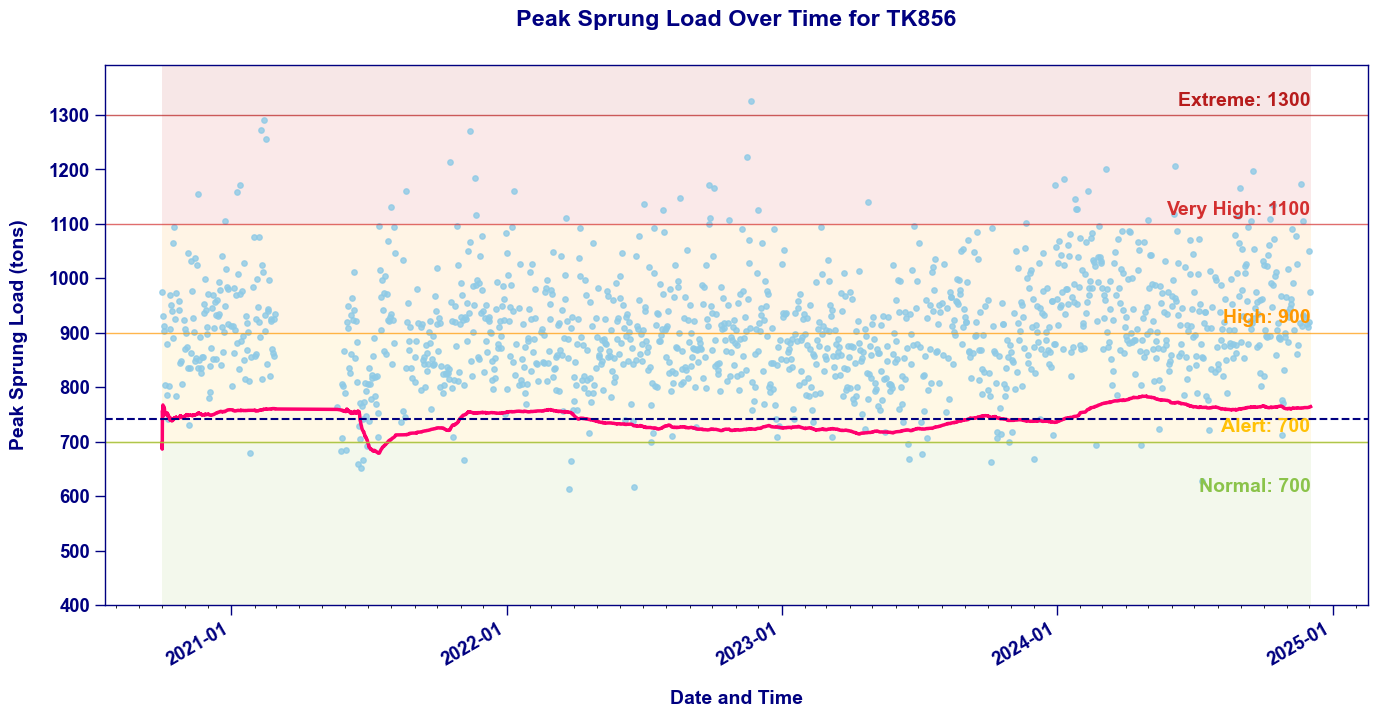

In [17]:
window_size = 30
figsize = (14, 8)
from matplotlib.patches import Rectangle

equipment_name = "TK856"
pandas_df = df.to_pandas()
# Filter for the specific equipment
equipment_df = df.filter(pl.col("equipment_name") == equipment_name)

# Convert to pandas and sort by datetime for proper plotting
filtered_df = equipment_df.to_pandas().sort_values("record_dt")

# Define the thresholds based on Image 2
thresholds = [
    {"level": "Normal", "max": 700, "color": "#8BC34A", "alpha": 0.1},  # Green
    {
        "level": "Alert",
        "min": 700,
        "max": 900,
        "color": "#FFC107",
        "alpha": 0.1,
    },  # Yellow
    {
        "level": "High",
        "min": 900,
        "max": 1100,
        "color": "#FF9800",
        "alpha": 0.1,
    },  # Orange
    {
        "level": "Very High",
        "min": 1100,
        "max": 1300,
        "color": "#D32F2F",
        "alpha": 0.1,
    },  # Dark Red
    {"level": "Extreme", "min": 1300, "color": "#B71C1C", "alpha": 0.1},  # Red
]

# Create theme and figure
theme = GGPrism()
fig, ax = theme.create_figure(figsize=figsize)

# Add threshold background regions
y_min = 400
y_max = max(1350, filtered_df["peak_sprung_load"].max() * 1.05)

# Draw the threshold background regions
for threshold in thresholds:
    if "min" not in threshold and "max" in threshold:
        # Normal range (below first threshold)
        rect = Rectangle(
            (filtered_df["record_dt"].min(), y_min),
            filtered_df["record_dt"].max() - filtered_df["record_dt"].min(),
            threshold["max"] - y_min,
            color=threshold["color"],
            alpha=threshold["alpha"],
            linewidth=0,
        )
        ax.add_patch(rect)
    elif "min" in threshold and "max" in threshold:
        # Middle ranges
        rect = Rectangle(
            (filtered_df["record_dt"].min(), threshold["min"]),
            filtered_df["record_dt"].max() - filtered_df["record_dt"].min(),
            threshold["max"] - threshold["min"],
            color=threshold["color"],
            alpha=threshold["alpha"],
            linewidth=0,
        )
        ax.add_patch(rect)
    else:
        # Extreme range (above highest threshold)
        rect = Rectangle(
            (filtered_df["record_dt"].min(), threshold["min"]),
            filtered_df["record_dt"].max() - filtered_df["record_dt"].min(),
            y_max - threshold["min"],
            color=threshold["color"],
            alpha=threshold["alpha"],
            linewidth=0,
        )
        ax.add_patch(rect)

# TECHNIQUE 1: Data reduction - resampling to daily mean for scatter plot
# This reduces the number of points while preserving the data patterns
daily_df = (
    filtered_df.resample("1D", on="record_dt")
    .agg({"peak_sprung_load": "max", "rolling_peak_sprung_load": "max"})
    .reset_index()
)


# Plot the downsampled points (daily averages)
ax.scatter(
    daily_df["record_dt"],
    daily_df["peak_sprung_load"],
    color="#8ECAE6",  # Light blue
    alpha=0.8,
    s=15,
    label="Daily Average",
)

# Plot the rolling mean with a thicker line
ax.plot(
    filtered_df["record_dt"],
    filtered_df["rolling_peak_sprung_load"],
    color="#FF006E",  # Magenta/pink
    linewidth=2.5,
    label=f"{window_size}-Day Rolling Mean",
)

# Add threshold lines
for threshold in thresholds:
    if "min" in threshold:
        ax.axhline(
            y=threshold["min"],
            color=threshold["color"],
            linestyle="-",
            linewidth=1.0,
            alpha=0.7,
        )
        # Add text labels for the thresholds on the right side

        ax.text(
            filtered_df["record_dt"].max(),
            threshold["min"] + 10,
            f"{threshold['level']}: {threshold['min']}",
            verticalalignment="bottom",
            horizontalalignment="right",
            color=threshold["color"],
            fontweight="bold",
        )

# Add a horizontal line for Normal threshold
ax.axhline(
    y=thresholds[0]["max"],
    color=thresholds[0]["color"],
    linestyle="-",
    linewidth=1.0,
    alpha=0.7,
)
ax.text(
    filtered_df["record_dt"].max(),
    thresholds[0]["max"] - 100,
    f"Normal: {thresholds[0]['max']}",
    verticalalignment="bottom",
    horizontalalignment="right",
    color=thresholds[0]["color"],
    fontweight="bold",
)

# Add a horizontal line for the overall mean
overall_mean = filtered_df["peak_sprung_load"].mean()
ax.axhline(
    y=overall_mean,
    color="navy",
    linestyle="--",
    linewidth=1.5,
    label=f"Overall Mean: {overall_mean:.1f}",
)

# Set y-axis limits with some padding
ax.set_ylim(y_min, y_max)

# Apply theme's finalization
theme.finalize_plot(
    fig,
    ax,
    title=f"Peak Sprung Load Over Time for {equipment_name}",
    xlabel="Date and Time",
    ylabel="Peak Sprung Load (tons)",
    legend_title="Data View",
)

import matplotlib.dates as mdates

# Explicitly tell matplotlib these are dates
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

# Set appropriate tick locations (adjust as needed)
ax.xaxis.set_major_locator(mdates.YearLocator())
# For more detailed ticks, you can use:
ax.xaxis.set_minor_locator(mdates.MonthLocator())
# Format the x-axis dates
fig.autofmt_xdate()

In [102]:
thresholds

[{'level': 'Normal', 'max': 700, 'color': '#8BC34A', 'alpha': 0.1},
 {'level': 'Alert', 'min': 700, 'max': 900, 'color': '#FFC107', 'alpha': 0.1},
 {'level': 'High', 'min': 900, 'max': 1100, 'color': '#FF9800', 'alpha': 0.1},
 {'level': 'Very High',
  'min': 1100,
  'max': 1300,
  'color': '#D32F2F',
  'alpha': 0.1},
 {'level': 'Extreme', 'min': 1300, 'color': '#B71C1C', 'alpha': 0.1}]

In [99]:
thresholds

[{'level': 'Alert', 'min': 700, 'max': 900, 'color': '#FFC107', 'alpha': 0.1},
 {'level': 'High', 'min': 900, 'max': 1100, 'color': '#FF9800', 'alpha': 0.1},
 {'level': 'Very High',
  'min': 1100,
  'max': 1300,
  'color': '#D32F2F',
  'alpha': 0.1},
 {'level': 'Extreme', 'min': 1300, 'color': '#B71C1C', 'alpha': 0.1}]

# Completitud

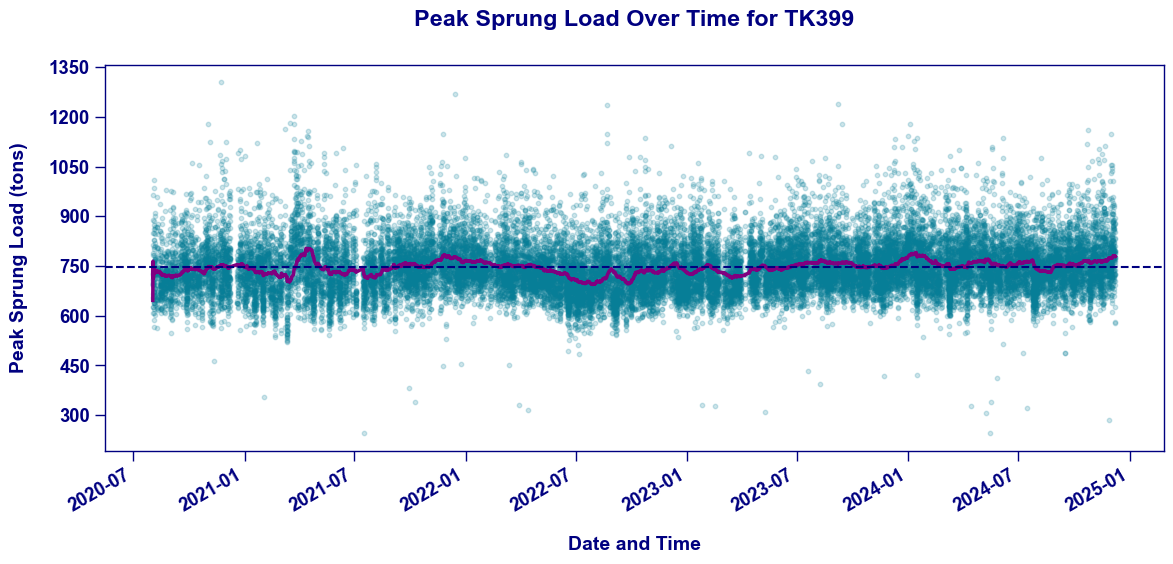

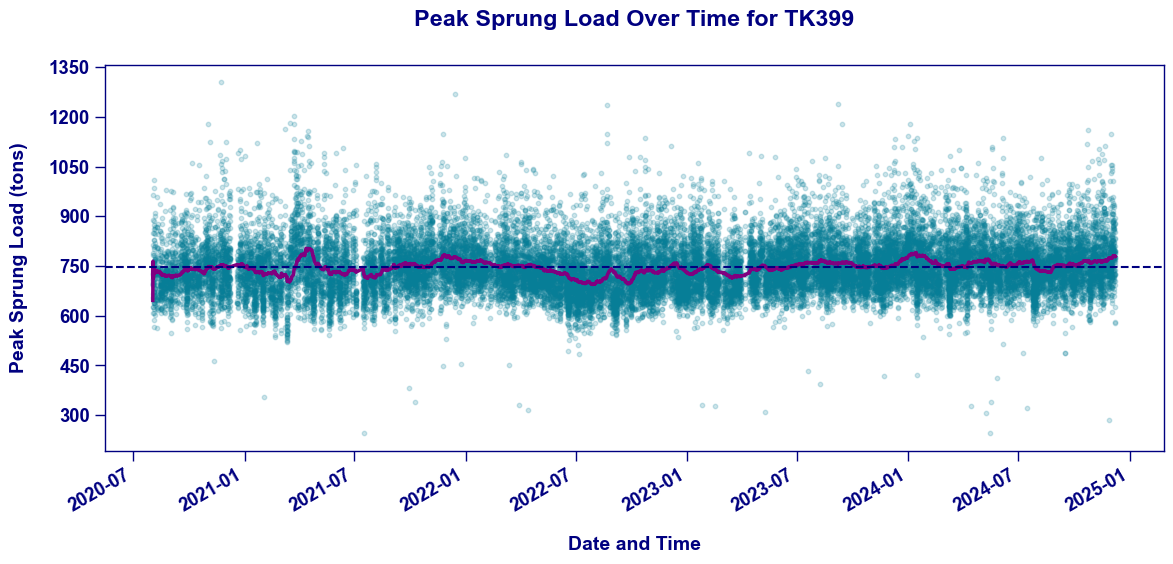

In [10]:
def plot_peak_sprung_load(df, equipment_name="TK399", window_size=30):
    """
    Plot Peak Sprung Load over time for a specific equipment using the GGPrism theme.
    Includes a rolling mean to smooth out the data.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the haul cycle data
    equipment_name : str
        The name of the equipment to filter for
    window_size : int
        Number of days for calculating the rolling mean
    """
    # Filter for the specified equipment
    filtered_df = df[df["equipment_name"] == equipment_name].copy()

    if filtered_df.empty:
        print(f"No data found for equipment {equipment_name}")
        return None

    # Handle datetime conversion robustly
    if pd.api.types.is_datetime64_any_dtype(filtered_df["metric_date"]):
        try:
            filtered_df["datetime"] = pd.to_datetime(
                filtered_df["metric_date"].dt.strftime("%Y-%m-%d")
                + " "
                + filtered_df["PTime"],
                errors="coerce",
            )
        except:
            # Backup approach
            try:
                time_parts = filtered_df["PTime"].str.split(":", expand=True)
                hours = time_parts[0].astype(float).astype(int)
                minutes = time_parts[1].astype(float).astype(int)
                seconds = time_parts[2].astype(float).astype(int)

                filtered_df["datetime"] = filtered_df["metric_date"] + pd.to_timedelta(
                    hours * 3600 + minutes * 60 + seconds, unit="s"
                )
            except:
                # Last resort
                filtered_df["datetime"] = filtered_df["metric_date"]
    else:
        filtered_df["datetime"] = pd.to_datetime(
            filtered_df["metric_date"] + " " + filtered_df["PTime"], errors="coerce"
        )

    # Drop any rows with invalid datetime
    filtered_df = filtered_df.dropna(subset=["datetime"])

    # Sort by datetime
    filtered_df = filtered_df.sort_values("datetime")

    # Calculate rolling mean (use 'D' for day frequency)
    # First set datetime as index
    temp_df = filtered_df.set_index("datetime")
    # Calculate the rolling mean with the specified window size
    rolling_mean = temp_df["Peak_Sprung_Load"].rolling(window=f"{window_size}D").mean()
    # Reset index to get back the datetime column
    rolling_mean = rolling_mean.reset_index()

    # Create a GGPrism theme instance
    theme = GGPrism()

    # Create figure and axes with the theme
    fig, ax = theme.create_figure(figsize=(12, 6))

    # Plot the individual data points with reduced opacity
    ax.scatter(
        filtered_df["datetime"],
        filtered_df["Peak_Sprung_Load"],
        color=theme.COLORS[0],
        alpha=0.2,
        s=10,
        label="Raw Data",
    )

    # Plot the rolling mean with a thicker line
    ax.plot(
        rolling_mean["datetime"],
        rolling_mean["Peak_Sprung_Load"],
        color=theme.COLORS[1],
        linewidth=2.5,
        label=f"{window_size}-Day Rolling Mean",
    )

    # Add a horizontal line for the global mean
    global_mean = filtered_df["Peak_Sprung_Load"].mean()
    ax.axhline(
        y=global_mean,
        color=theme.COLORS[2],
        linestyle="--",
        linewidth=1.5,
        label=f"Global Mean: {global_mean:.1f}",
    )

    # Apply theme's finalization with legend
    theme.finalize_plot(
        fig,
        ax,
        title=f"Peak Sprung Load Over Time for {equipment_name}",
        xlabel="Date and Time",
        ylabel="Peak Sprung Load (tons)",
        legend_title="Data View",
    )

    # Format the x-axis dates
    plt.gcf().autofmt_xdate()

    return fig


plot_peak_sprung_load(df)

In [3]:
df.head(10).to_csv("example.csv", index=False)